# Predator-Prey Dynamics Model


## Introduction

The following tutorial aims to describe a more dynamic model using the `ABSESpy`. It consists of an implementation of the Lotka-Volterra model which presents a simple ecosystem with two species: predators and preys. This model was originally proposed as a system of first-order, non-linear differential equations and has found its computation, individual-based simulation counterparts.

This introductory tutorial illustrates:

1. Converting a property of `PatchCell` to raster attribute.
2. Managing different breeds of `Actor` and their parameters.
3. Implement randomly actions of `Actor`.

The model aims to capture the dynamical evolution of the population of wolves and the population of sheep. It recreates a simple food chain where wolves feed on sheep and, in turn, sheep feed on grass. Both sheep and wolves have energy levels that are invariable affected by their movement. A move costs energy that can only be replenish by eating. 

## The Grass Patchcell


In [1]:
import random

from loguru import logger

from abses import Actor, MainModel, PatchCell
from abses.cells import raster_attribute

As is it usual with a heuristic model, we want to place our agents in an virtual environment. ABSESpy offers the posibility to create a grid by means of the create_module method of the BaseNature class. It is often not necessary to import this class, nor other classes that support it, as the main class, MainModel, will create an instance of it at the moment of its creation. However, here we will import the PatchCell class to creating a subclass that will suit the needs of the model. Namely, we want our patch cells to contain grass for the sheep to eat.

We will pass this new class to the create_module method as a parameter. That will make it the default patch cell for the model.

The class Grass will be fundamentally the same as its parent class, PatchCell, except for the added property empty that will be used to determine whether there is grass on the cell currently or not. We will also need to method to regrow the grass after it has been consumed.

In [2]:
class Grass(PatchCell):
    """Custom patch cell class"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.empty = False
        self._countdown = 1

    def grow(self):
        """Grow some grass on the cell every 5 ticks."""
        # countdown on brown patches: if you reach 0, grow some grass
        if self.empty is True:
            if self._countdown <= 0:
                self.empty = False
                self._countdown = 1
            else:
                self._countdown -= 1

    @raster_attribute
    def empty(self) -> bool:
        """Return True if the cell is empty, False otherwise."""
        return self._empty

    @empty.setter
    def empty(self, value: bool) -> None:
        """Set the empty status of the cell."""
        self._empty = value

## Agents Classes

We need at least two custom classes. One to represent wolves and another to represent sheep. Across these two classes there is common functionality that can be abstracted into a parent class. In particular, we may want to define a shared method for movement, reproduction and energy consumption. From there, a class Wolf can be define to handle how the wolves will feed on sheep and a class Sheep to handle how the sheep will feed on grass.

The parent class Animal will have the following properties:

- energy: the amount of energy the animal has. It will be used to determine whether the animal can move or reproduce.
- rep_rate: the rate at which the animal reproduces. It will be used to determine whether the animal can reproduce.
There will be methods defined for this class to handle agents' movement, reproduction and death.

In [3]:
class Animal(Actor):
    """Custom animal"""

    def __init__(self, *args, **kwargs):
        Actor.__init__(self, *args, **kwargs)
        self.energy = 5

    def update(self):
        """Update the animal's state."""
        # consume energy
        self.energy -= 1
        if self.energy <= 0:
            self.die()

    def move_randomly(self):
        """Move randomly."""
        prob = [
            random.choice(range(4)) for i in range(len(self.at.neighboring()))
        ]
        self.move.random(prob=prob)

    def reproduce(self):
        """Reproduce if there's enough energy."""
        if self.random.random() < self.params.rep_rate:
            self.energy /= 2
            self.at.agents.new(self.__class__)

At each step, both sheep and wolves will move randomly to a new neighboring cell. Then, they will eat if there is food avaiable to them. Given a certain probability, they will reproduce. That probability is determined by the rep_rate property. Finally, they will be lose some energy.

In [4]:
class Wolf(Animal):
    """Custom wolf."""

    def step(self):
        self.move_randomly()
        self.eat_sheep()
        self.reproduce()
        self.update()

    def eat_sheep(self):
        """If there is a sheep in the cell, eat it and gain energy."""
        sheep_here = self.at.agents.select("Sheep")
        if a_sheep := sheep_here.random.choice(when_empty="return None"):
            a_sheep.die()
            self.energy += 5


class Sheep(Animal):
    """Custom sheep."""

    def step(self):
        self.move_randomly()
        self.eat_grass()
        self.reproduce()
        self.update()

    def eat_grass(self):
        """If there is grass in the cell, eat it and gain energy."""
        if self.get("empty", target="cell") is False:
            self.energy += 5
            self.set("empty", True, target="cell")

## The Model

Our model consists of two components. One initialization method and a step method. Most of the complexity of the model lies in interaction between agents and the added feature of the grass patch cells.

The WolfSheepModel class is a subclass of MainModel and represents a simulation model for a predator-prey system involving wolves and sheep. In the constructor (init), the model initializes a grid with cells represented by the Grass class. It then creates a list of all cells in the grid. The model creates a specified number of Wolf and Sheep agents with given reproduction rates. These agents are then placed randomly on the grid. A DataCollector instance is also initialized to track the populations of wolves and sheep in the model.

The step method represents a single time step in the simulation. In each time step, the step method of all Sheep and Wolf agents is triggered, allowing them to perform their actions. Then, the grow_grass method is called for each cell in the grid, simulating the growth of grass. The model checks if the populations of sheep and wolves are empty or if the population of sheep has reached 400, in which case it stops the simulation by setting self.running to False. Finally, the collect method of the DataCollector is called to collect data for the current time step.

In [5]:
class WolfSheepModel(MainModel):
    """Wolf-Sheep predation tutorial model."""

    def setup(self):
        # initialize a grid
        grassland = self.nature.create_module(
            how="from_resolution",
            shape=self.params.shape,
            name="grassland",
            cell_cls=Grass,
        )
        # add sheep and wolves
        self.agents.new(Wolf, self.params.n_wolves)
        self.agents.new(Sheep, self.params.n_sheep)
        # without a specific position, agents will move randomly on the layer.
        self.agents.apply(lambda a: a.move.to("random", layer=grassland))

    def step(self):
        self.agents.select("Sheep").trigger("step")
        self.agents.select("Wolf").trigger("step")
        self.nature.grassland.apply(lambda c: c.grow())
        self.check_end()

    def check_end(self):
        """Check if the model should stop."""
        # end model
        if not self.agents.has("Sheep"):
            self.running = False
        elif not self.agents.has("Wolf"):
            self.running = False
        elif self.agents.has("Sheep") >= 1200:
            self.running = False

    @property
    def n_grass(self):
        """Return the number of grass patches."""
        empty = self.nature.grassland.get_raster("empty")
        return empty.size - empty.sum()

## Simulations

We are now able to run simulations. We instantiate a model to run for 100 steps. It will have a ratio of 4 sheep for every wolf. We keep the reproduction rates low. We will then plot the resulting evolution in the populations of wolves and sheep. 

In [6]:
parameters = {
    "time": {"end": 100},
    "reports": {
        "model": {
            "n_sheep": ':lambda x: x.agents.has("Sheep")',
            "n_wolves": ':lambda x: x.agents.has("Wolf")',
            "n_grass": ":lambda x: x.n_grass",
        }
    },
    "model": {
        "shape": (12, 12),
        "n_sheep": 100,
        "n_wolves": 5,
    },
    "wolf": {"rep_rate": 0.05, "min_energy": 10},
    "sheep": {"rep_rate": 0.10, "min_energy": 6},
}

model = WolfSheepModel(parameters=parameters)
model.run_model()

In this single run, the results show diverging populations. At first, the sheep population declines and the wolf population increases. Then, the wolf population declines and the sheep population increases. All wolves disappear and the sheep population reaches the carrying capacity of the environment.

<Axes: >

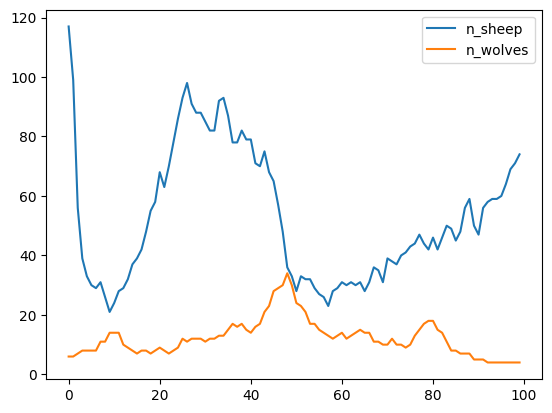

In [7]:
model.datacollector.get_model_vars_dataframe()[["n_sheep", "n_wolves"]].plot()